# BindsNETで神経シミュレーション
BindsNETは単なるシミュレーションとしての用途だけではなく、SNN(Spiking Neural Network)として機械学習を行うことが可能です。

順番に Shift + Enter を押していくだけで、シミュレーションが可能です。

参考文献

１．公式ドキュメント　https://bindsnet-docs.readthedocs.io/

２．BindsNETでSNNを試してみる　https://qiita.com/takeajioka/items/98225ce8c2ce953c5fd5

３．Spiking Neural Networksライブラリ ー BindsNETを触ってみる【Python】 https://hirlab.net/nblog/category/programming/art_599/　

## インストール

In [1]:
!pip install bindsnet

     |████████████████████████████████| 71kB 4.5MB/s 
     |████████████████████████████████| 317kB 25.7MB/s 
  Created wheel for bindsnet: filename=bindsnet-0.2.7-cp36-none-any.whl size=81417 sha256=d036fd174ac44c700d8252a0e9cf86ae6c10d6b735c5e6c71848cc607ae38d5e
  Stored in directory: /root/.cache/pip/wheels/d3/68/80/eca244a3d072961b5152d5906475ffc9d9b2453c9e060535e3
Successfully built bindsnet



これで、GoogleColab上でBindsNETが使えるようになりました。(制限時間12時間)

次からは、デモを行います。

## デモ１　ネットワークのシミュレーション

In [2]:
import torch
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages

# Simulation time.
time = 500

# Create the network.
network = Network()

# Create and add input, output layers.
source_layer = Input(n=100)
target_layer = LIFNodes(n=10)

network.add_layer(
    layer=source_layer, name="A"
)
network.add_layer(
    layer=target_layer, name="B"
)


In [3]:
# Create connection between input and output layers.
forward_connection = Connection(
    source=source_layer,
    target=target_layer,
    w=0.05 + 0.1 * torch.randn(source_layer.n, target_layer.n),  # Normal(0.05, 0.01) weights.
)

network.add_connection(
    connection=forward_connection, source="A", target="B"
)

In [4]:
# Create recurrent connection in output layer.
recurrent_connection = Connection(
    source=target_layer,
    target=target_layer,
    w=0.025 * (torch.eye(target_layer.n) - 1), # Small, inhibitory "competitive" weights.
)

network.add_connection(
    connection=recurrent_connection, source="B", target="B"
)

In [5]:
network

Network(
  (A): Input()
  (B): LIFNodes()
  (A_to_B): Connection(
    (source): Input()
    (target): LIFNodes()
  )
  (B_to_B): Connection(
    (source): LIFNodes()
    (target): LIFNodes()
  )
)

In [6]:
# Create and add input and output layer monitors.
source_monitor = Monitor(
    obj=source_layer,
    state_vars=("s",),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)
target_monitor = Monitor(
    obj=target_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=target_monitor, name="B")


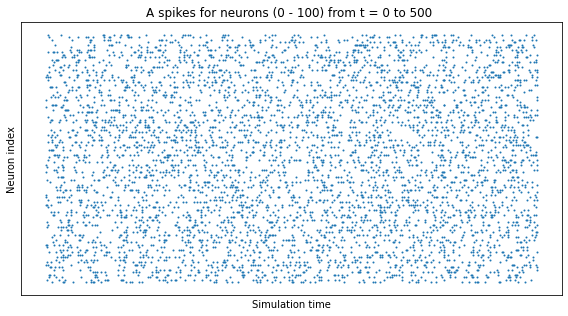

In [7]:
# Create input spike data （p = 0.1のベルヌーイ分布で入力スパイクを作成）
input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
inputs = {"A": input_data}
plot_spikes(inputs)
plt.show()

In [8]:
# Simulate network on input data.
network.run(inputs=inputs, time=time)

In [9]:
# Retrieve and plot simulation spike, voltage data from monitors.
spikes = {
    "A": source_monitor.get("s"), "B": target_monitor.get("s")
}
voltages = {"B": target_monitor.get("v")}

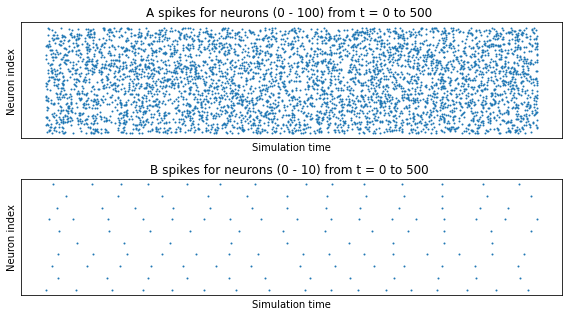

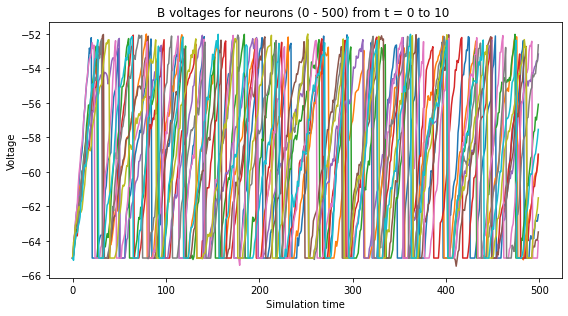

In [10]:
plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()

BindsNETでは活動電位までは再現されない。(LIFニューロンモデルのため)

また、100以上の細胞ではラスタープロットが表示されないバグがあった。

## デモ２　SNNでMNISTを学習してみる
MNISTは手書きの数字認識を行うためのデータセットです。

https://github.com/HiroshiARAKI/snnlibpy で公開されているWrapperを使うと簡単に行うことが出来ます。

In [11]:
!git clone https://github.com/HiroshiARAKI/snnlibpy.git

Cloning into 'snnlibpy'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 344 (delta 43), reused 85 (delta 29), pack-reused 245
Receiving objects: 100% (344/344), 5.01 MiB | 993.00 KiB/s, done.
Resolving deltas: 100% (165/165), done.


In [12]:
from snnlibpy.wbn import Spiking

In [13]:
# Build SNNs and decide the number of input neurons and the simulation time.
snn = Spiking(input_l=784, obs_time=100, dt=1.0)

# Add a layer and give the num of neurons and the neuron model.
snn.add_layer(n=100,
              node=snn.DIEHL_COOK,          # or snn.DIEHL_COOK
              w=snn.W_SIMPLE_RAND,   # initialize weights
              rule=snn.SIMPLE_STDP,  # learning rule
              nu=(1e-4, 1e-2),       # learning rate
              )

# Add an inhibitory layer
snn.add_inhibit_layer(inh_w=-128)

You Called Spiking Neural Networks Library "WBN"!!
=> WrappedBindsNET (This Library) :version. 0.2.6
-- Added fc-0 with the Learning rule, Simple_STDP
-- Added inh[fc-0] as an inhibitory layer


In [14]:
# Check your network architecture
snn.print_model()

Show your network information below.
Layers:
 in(784)
    |
 fc-0(100)
    |
 inh[fc-0](100)
    |
  [END]
Simulation Time: 100, dt: 1.0


In [15]:
# Load dataset
snn.load_MNIST()

Extracting /content/data/mnist/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz to /content/data/mnist/TorchvisionDatasetWrapper/raw


Extracting /content/data/mnist/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz to /content/data/mnist/TorchvisionDatasetWrapper/raw


Extracting /content/data/mnist/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz to /content/data/mnist/TorchvisionDatasetWrapper/raw


Extracting /content/data/mnist/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz to /content/data/mnist/TorchvisionDatasetWrapper/raw
Processing...
Done!


In [16]:
# Use gpu (しなくても可)
snn.to_gpu()

GPU computing is available.


True

Plot weight map 100/100
Plotting... Done!


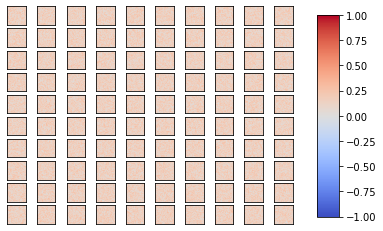

In [17]:
# Plot weight maps before training
snn.plot(plt_type='wmps', prefix='0', save=False, f_shape=(10, 10))

In [18]:
# Make my network run（30分ほどかかる）
snn.run(tr_size=10000, unsupervised=False)

Progress: 10000 / 10000 (1690.0047 seconds): 10000it [28:10,  5.52it/s]

Progress: 10000 / 10000 (1690.1761 seconds)
===< Have finished running the network >===



Plot weight map 100/100
Plotting... Done!


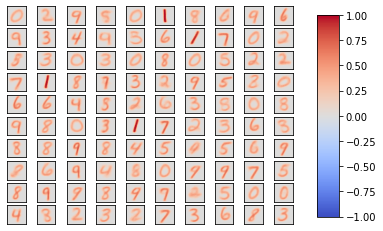

In [19]:
# Plot weight maps after training
snn.plot(plt_type='wmps', save=False, prefix='result', f_shape=(10, 10))

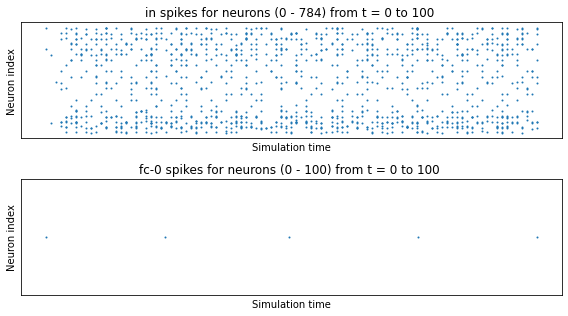

In [23]:
# Plot output spike trains after training
snn.plot(plt_type='sp', save=False,range=1)

シミュレーションによって、Weight Mapに数字が写し出されるようになった。

また画像の入力に対して、一定の細胞が反応している。（ただし本当はもっと時間をかけて学習させる必要がある。）